In [2]:
import pandas as pd
import numpy as np


In [3]:
# Load dataset
df = pd.read_csv('ai4i2020.csv')

# Drop columns that cause data leakage or are not useful
df_model = df.drop(columns=['UDI', 'Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'])

# One-Hot Encoding for equipment type
df_model = pd.get_dummies(df_model, columns=['Type'], drop_first=True)

In [4]:
from sklearn.model_selection import train_test_split

# Features and target
X = df_model.drop('Machine failure', axis=1)
y = df_model['Machine failure']

# Train-test split (stratified due to class imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [6]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

model.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions
y_pred = model.predict(X_test_scaled)

# Classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      1932
           1       0.14      0.82      0.24        68

    accuracy                           0.82      2000
   macro avg       0.57      0.82      0.57      2000
weighted avg       0.96      0.82      0.88      2000



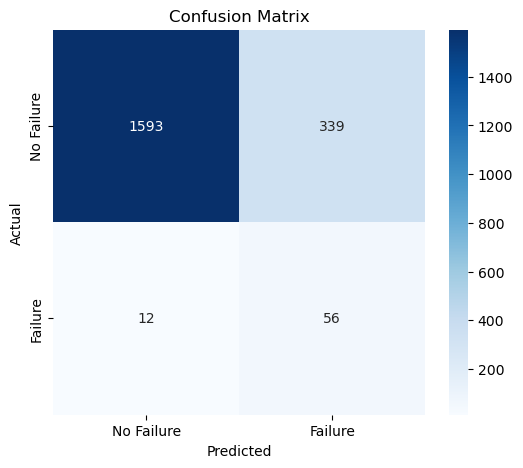

In [8]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['No Failure', 'Failure'],
    yticklabels=['No Failure', 'Failure']
)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [9]:
import numpy as np
import pandas as pd


In [10]:
# Select only failed machines
failed_data = df[df['Machine failure'] == 1]

# Use Tool wear as a proxy for Time-to-Failure
time_to_failure = failed_data['Tool wear [min]']

print(f"Number of failure samples: {len(time_to_failure)}")


Number of failure samples: 339


In [13]:
from scipy.stats import weibull_min


In [14]:
# Fit Weibull distribution (location fixed at 0)
shape, loc, scale = weibull_min.fit(time_to_failure, floc=0)

print(f"Shape (β): {shape:.2f}")
print(f"Scale (η): {scale:.2f}")


Shape (β): 1.95
Scale (η): 160.81


In [15]:
import matplotlib.pyplot as plt


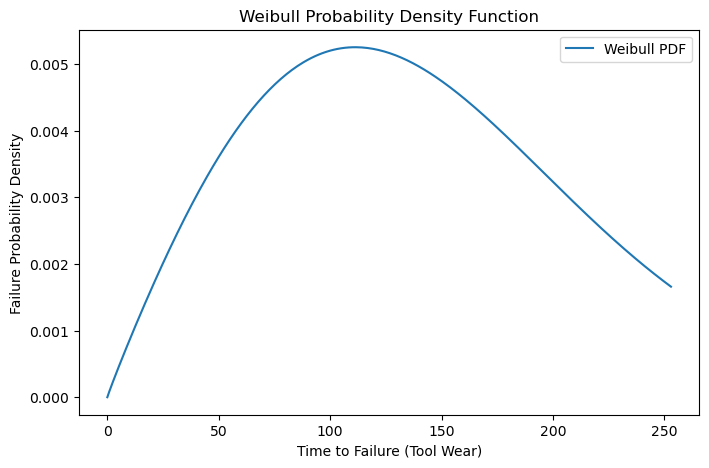

In [16]:
# Generate values for plotting
x = np.linspace(0, time_to_failure.max(), 300)

# Probability Density Function
pdf = weibull_min.pdf(x, shape, loc, scale)

plt.figure(figsize=(8, 5))
plt.plot(x, pdf, label='Weibull PDF')
plt.xlabel('Time to Failure (Tool Wear)')
plt.ylabel('Failure Probability Density')
plt.title('Weibull Probability Density Function')
plt.legend()
plt.show()


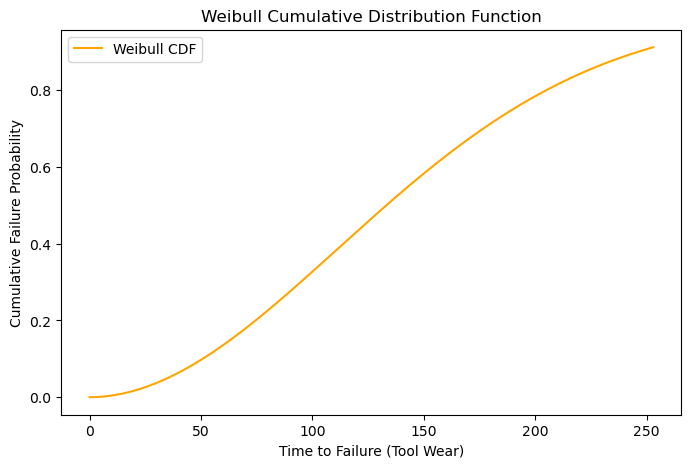

In [17]:
# Cumulative Distribution Function
cdf = weibull_min.cdf(x, shape, loc, scale)

plt.figure(figsize=(8, 5))
plt.plot(x, cdf, color='orange', label='Weibull CDF')
plt.xlabel('Time to Failure (Tool Wear)')
plt.ylabel('Cumulative Failure Probability')
plt.title('Weibull Cumulative Distribution Function')
plt.legend()
plt.show()


In [18]:
! pip install joblib


In [19]:
import joblib

# Save trained model
joblib.dump(model, 'machine_failure_model.pkl')

# Save scaler
joblib.dump(scaler, 'scaler.pkl')

print("✅ Model and Scaler saved successfully")


✅ Model and Scaler saved successfully
